# Dataset Description

Download the dataset using following API command - `kaggle competitions download -c mercari-price-suggestion-challenge`



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
MERCARI_PATH_TRAIN = os.path.join(os.getcwd(), "dataset/mercari-price-suggestion-challenge/train.tsv")
MERCARI_PATH_TEST = os.path.join(os.getcwd(), "dataset/mercari-price-suggestion-challenge/test.tsv")

In [3]:
data1 = pd.read_csv(MERCARI_PATH_TRAIN, delimiter='\t')
data2 = pd.read_csv(MERCARI_PATH_TEST, delimiter='\t')

data = pd.concat([data1, data2])
data = data.drop(["train_id", "test_id"], axis=1)
data = data.reset_index(drop=True)
data.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [4]:
data.shape

(2175894, 7)

In [5]:
data.isna().sum()

name                      0
item_condition_id         0
category_name          9385
brand_name           928207
price                693359
shipping                  0
item_description          4
dtype: int64

NA values for brand name could be for unbranded goods

We may also need to train a model where there is no category or item_description provided

In [6]:
data.duplicated().sum()

85

In [7]:
data.name.value_counts()

Bundle                                   3343
Reserved                                  696
Converse                                  656
Dress                                     606
BUNDLE                                    599
                                         ... 
Short jumpsuit                              1
purple nikes                                1
Malibu heat                                 1
NEW ** TC LULAROE ** LEOPARD/CHEETAH        1
FREESHIP 2 Floral Scrub Tops, medium.       1
Name: name, Length: 1750617, dtype: int64

This column is not categorical and potentially at test time a new name of the product may be given

In [8]:
data.item_condition_id.value_counts()

1    940630
3    633834
2    551032
4     46815
5      3583
Name: item_condition_id, dtype: int64

condition_id is categorical with only 5 values

In [9]:
data.category_name.value_counts()

Women/Athletic Apparel/Pants, Tights, Leggings    88077
Women/Tops & Blouses/T-Shirts                     68082
Beauty/Makeup/Face                                50352
Beauty/Makeup/Lips                                44028
Electronics/Video Games & Consoles/Games          39178
                                                  ...  
Handmade/Toys/Doll Clothes                            1
Handmade/Holidays/Patriotic                           1
Handmade/Accessories/Cuff                             1
Other/Pet Supplies/Pet Food                           1
Handmade/Toys/Baby                                    1
Name: category_name, Length: 1310, dtype: int64

Seems like we have to extract multiple categories from the categorical column and build a huge sparse matrix (consisting only of categories)

In [10]:
"""
num_cats = set()
for i in range(data.shape[0]):
    if not data.loc[i, 'category_name'].is_na():
        num_cats.add(len(data.loc[i, 'category_name'].split("/")))
print("Distinct number of categories :", num_cats)

del num_cats
num_cats = {1:0, 2:0, 3:0, 4:0, 5:0}
for i in range(data.shape[0]):
    num_cats[len(data.loc[i, 'category_name'].split("/"))] += 1
print("number of records with given num of categories", num_cats)
"""

'\nnum_cats = set()\nfor i in range(data.shape[0]):\n    if not data.loc[i, \'category_name\'].is_na():\n        num_cats.add(len(data.loc[i, \'category_name\'].split("/")))\nprint("Distinct number of categories :", num_cats)\n\ndel num_cats\nnum_cats = {1:0, 2:0, 3:0, 4:0, 5:0}\nfor i in range(data.shape[0]):\n    num_cats[len(data.loc[i, \'category_name\'].split("/"))] += 1\nprint("number of records with given num of categories", num_cats)\n'

There are only upto 5 categories per record and majority records have only 3 categories so we'll transform the records to only have first 3 categories (and discard others or keep them empty)

In [11]:
data.brand_name.value_counts()

Nike                 79277
PINK                 79092
Victoria's Secret    70508
LuLaRoe              45598
Apple                25435
                     ...  
!iT Jeans                1
Ware                     1
Edelbrock                1
Piazza Sempione          1
PediaCare                1
Name: brand_name, Length: 5289, dtype: int64

Only few brand names but the column doesn't seem to be categorical

In [12]:
data.shipping.value_counts()

0    1202364
1     973530
Name: shipping, dtype: int64

Shipping is categorical, whereas price is clearly a float and item description is a string

### Findings :
1. item_condition_id, shipping and potentially category_name column could be considered categorical
2. all the other columns are plain-text, and can be useful features in predicting price of an item (for eg: apple device might be more expensive than a similar samsung device etc.)

# EDA

## 1. Price Distribution

Most of the models work well when target value is normally distributed, so we'll look for common feature transforms that transforms the skewed distribution to normal distribution


### 1. No transform

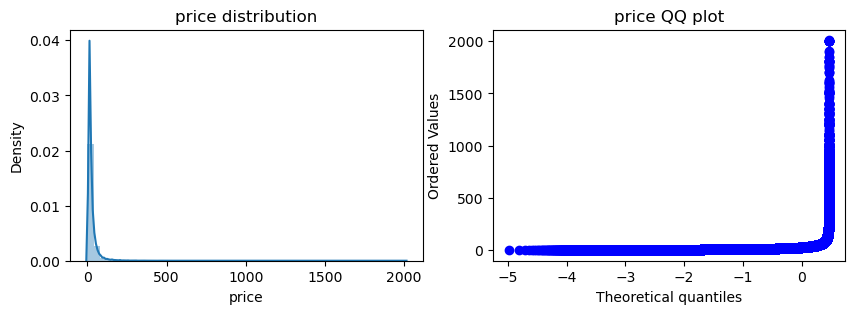

In [13]:
import warnings
import scipy.stats as stats
warnings.filterwarnings('ignore')
plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
sns.distplot(data['price'])
plt.title('price distribution')
plt.subplot(1, 2, 2)
stats.probplot(data['price'], dist="norm", plot=plt)
plt.title('price QQ plot')
plt.show()

### 2. log-transform

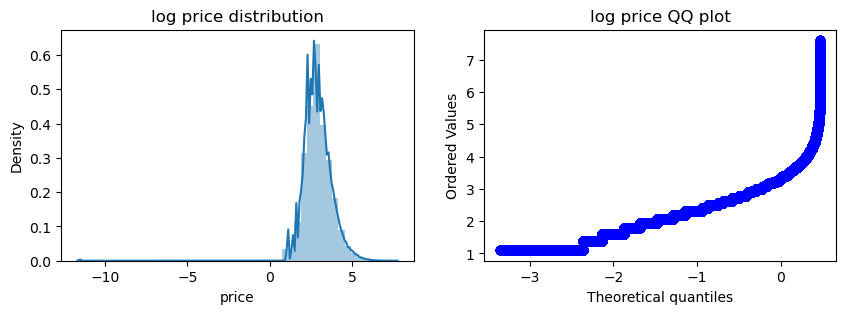

In [14]:
plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
sns.distplot(np.log(data['price']+0.00001))
plt.title('log price distribution')
plt.subplot(1, 2, 2)
stats.probplot(np.log(data['price']), dist="norm", plot=plt)
plt.title('log price QQ plot')
plt.show()

### 3. box-cox transform

lambda : 8.472135811722177


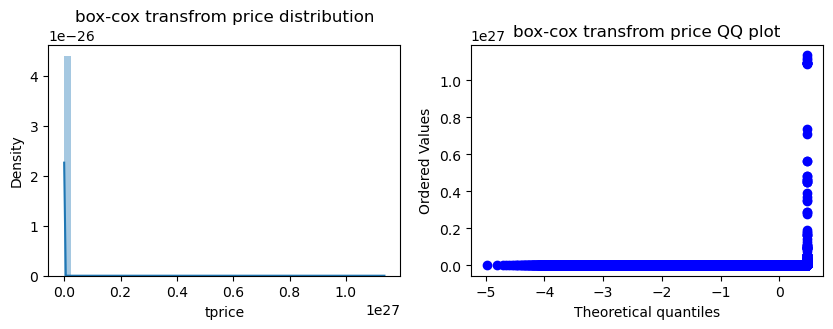

In [15]:
plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)

data['tprice'], lambda_ = stats.boxcox(data['price'] + 0.00001)
print('lambda :', lambda_)
sns.distplot(data['tprice'])
plt.title('box-cox transfrom price distribution')
plt.subplot(1, 2, 2)
stats.probplot(data['tprice'], dist="norm", plot=plt)
plt.title('box-cox transfrom price QQ plot')
plt.show()

We'll take the log-transformed price for now

In [16]:
data['tprice'] = np.log(data['price']+0.00001)

## 2. Distribution of other categorical attributes wrt price

<Axes: xlabel='item_condition_id', ylabel='tprice'>

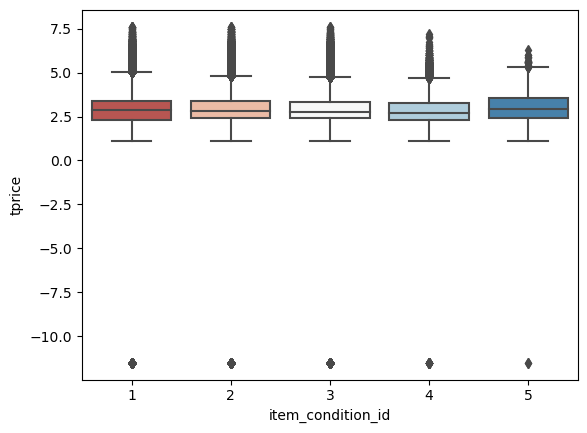

In [17]:
# distribution of tprice against different item conditions
sns.boxplot(x = 'item_condition_id', y = data['tprice'], data = data, palette = sns.color_palette('RdBu',5))

Price distribution is similar across item conditions

<Axes: xlabel='shipping', ylabel='tprice'>

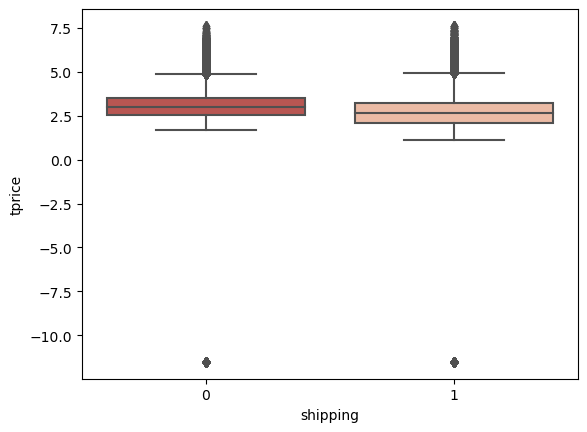

In [18]:
# distribution of tprice against shipping = 0 or 1
sns.boxplot(x = 'shipping', y = data['tprice'], data = data, palette = sns.color_palette('RdBu',5))

Distribution is nearly the same except when shipping = 0, price is slightly higher

# Data Pre-processing

In [19]:
# change the category_name column to have only upto 3 categories, and drop the old category column
data["category_name"].fillna(value='missing', inplace=True)
data[["cat1", "cat2", "cat3"]] = data["category_name"].str.split('/', expand=True)[[0, 1, 2]]

data["item_description"] = data["item_description"].replace({"No description yet":np.nan})
data['brand_name'].fillna(value='un-branded', inplace=True)
data['item_description'].fillna(value='missing', inplace=True)

data = data.drop("category_name", axis=1)

In [20]:
data["cat1"].fillna(value='missing', inplace=True)
data["cat2"].fillna(value='missing', inplace=True)
data["cat3"].fillna(value='missing', inplace=True)

In [21]:
for brand, v in data['brand_name'].value_counts().items():
    if v < 1000:
        data.loc[data['brand_name'] == brand, 'brand_name'] = 'others'

In [22]:
# One-hot encode each sparse category column
from sklearn.preprocessing import LabelBinarizer
cat_features = ["cat1", "cat2", "cat3", "brand_name"]
binarized_cols = []

for column in cat_features:
    binarizer = LabelBinarizer(sparse_output=True)
    binarized_col = binarizer.fit_transform(data[column])
    binarized_cols.append(binarized_col)

In [23]:
data = data.drop(["brand_name", "cat1", "cat2", "cat3"], axis=1)

In [25]:
data = pd.get_dummies(data=data, columns=['item_condition_id'])
data['shipping'] = data['shipping'].astype('uint8')

Computing TF-IDF for textual features : name and item_description

In [26]:
data['item_description'] = data['item_description'].astype('<U28')
data['name'] = data['name'].astype('<U28')

In [27]:
# Handle all the text data
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import PorterStemmer

data['name'] = data['name'].str.replace('\[rm\]', '')
data['item_description'] = data['item_description'].str.replace('\[rm\]', '')

data['name'] = data['name'].apply(lambda x: np.char.lower(x))
data['item_description'] = data['item_description'].apply(lambda x: np.char.lower(x))

data['name'] = data['name'].str.replace("'", "")
data['item_description'] =  data['item_description'].str.replace("'", "")

stemmer = PorterStemmer()
data['name'] = data['name'].apply(lambda x: stemmer.stem(x))
data['item_description'] = data['item_description'].apply(lambda x: stemmer.stem(x))

symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
for s in symbols:
    data['name'] = data['name'].str.replace(s, ' ')
    data['item_description'] = data['item_description'].str.replace(s, ' ')

In [28]:
# Create TF-IDF vectorizer
vectorized_cols = []
tfidf_vectorizer = TfidfVectorizer(min_df=7, max_features=10000)
vectorized_col = tfidf_vectorizer.fit_transform(data["name"])
vectorized_cols.append(vectorized_col)

tfidf_vectorizer = TfidfVectorizer(min_df=15, ngram_range=(1, 2), max_features=40000)
vectorized_col = tfidf_vectorizer.fit_transform(data["item_description"])
vectorized_cols.append(vectorized_col)

data = data.drop(["name", "item_description"], axis=1)

In [29]:
data.head()

,price,shipping,tprice,item_condition_id_1,item_condition_id_2,item_condition_id_3,item_condition_id_4,item_condition_id_5
0,10.0,1,2.302586,0,0,1,0,0
1,52.0,0,3.951244,0,0,1,0,0
2,10.0,1,2.302586,1,0,0,0,0
3,35.0,1,3.555348,1,0,0,0,0
4,44.0,0,3.784190,1,0,0,0,0


In [ ]:
X = np.hstack((binarized_cols[0], binarized_cols[1], binarized_cols[2], binarized_cols[3],
               data[''], , vectorized_cols[0], vectorized_cols[1]))
y = data["tprice"]